In [207]:
import numpy as np
import pandas as pd
from scipy.io import loadmat
import matplotlib.pyplot as plt
%matplotlib inline

In [208]:
from __future__ import print_function

import keras
from keras import metrics
from keras.datasets import mnist
from keras.models import Sequential
from keras.optimizers import RMSprop, SGD
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv3D, MaxPooling3D, LeakyReLU

In [209]:
"""
Returns the tau's to be predicted
"""
def get_output_data():
    tau_11 = loadmat('tau11_xyz_T1.mat')['tau11']
    tau_12 = loadmat('tau12_xyz_T1.mat')['tau12']
    tau_13 = loadmat('tau13_xyz_T1.mat')['tau13']
    tau_22 = loadmat('tau22_xyz_T1.mat')['tau22']
    tau_23 = loadmat('tau23_xyz_T1.mat')['tau23']
    tau_33 = loadmat('tau33_xyz_T1.mat')['tau33']
    return tau_11, tau_12, tau_13, tau_22, tau_23, tau_33

In [210]:
"""
Returns the heat's to be predicted
"""
def get_output_data_heat():
    heat_1 = loadmat('Heat1_xyz_T1.mat')['Heat1']
    heat_2 = loadmat('Heat2_xyz_T1.mat')['Heat2']
    heat_3 = loadmat('Heat3_xyz_T1.mat')['Heat3']
    return heat_1, heat_2, heat_3

In [211]:
"""
Returns the tau's to be predicted
"""
def get_input_data_heat():
    uf = loadmat('u_F_xyz_T1.mat')['u_F']
    vf = loadmat('v_F_xyz_T1.mat')['v_F']
    wf = loadmat('w_F_xyz_T1.mat')['w_F']
    theta = loadmat('theta_F_xyz_T1.mat')['theta_F']
    grad = loadmat('grad_Tz_F_xyz_T1.mat')['grad_T_z']
    return uf, vf, wf, theta, grad

In [212]:
"""
Returns the tau's to be predicted
"""
def get_input_data():
    uf = loadmat('u_F_xyz_T1.mat')['u_F']
    vf = loadmat('v_F_xyz_T1.mat')['v_F']
    wf = loadmat('w_F_xyz_T1.mat')['w_F']
    tke = loadmat('TKE_F_xyz_T1.mat')['TKE_F']
    return uf, vf, wf, tke

In [213]:
"""
Explores Dataset
"""
def explore_data(data):
    plt.figure(figsize=(15,5))
    # Varying by X
    plt.subplot(1,3,1)
    plt.plot(data[:,0,0])
    # Varying by Y
    plt.subplot(1,3,2)
    plt.plot(data[0,:,0])
    # Varying by Z
    plt.subplot(1,3,3)
    plt.plot(data[0,0,:])
    plt.show()

In [214]:
"""
Denormalizes Outputs
"""
def denormalize_data(train, test):
    mu, std = np.mean(train.flatten()), np.std(train.flatten())
    train_new = (train - mu)/std
    test_new = (test - mu)/std
    print()
    return train_new, test_new, mu, std

In [215]:
"""
Reshapes Data and split data into train and test sets
"""
def create_train_test_sets(tau_11, tau_12, tau_13, tau_22, tau_23, tau_33,
                           uf, vf, wf, tke,
                           train_pct, size = 1):
    
    x_dataset = np.transpose(np.array([uf.flatten(), vf.flatten(), wf.flatten(), tke.flatten()]))
    
    tau_11_dataset = np.transpose(np.array([tau_11.flatten()]))
    tau_12_dataset = np.transpose(np.array([tau_12.flatten()]))
    tau_13_dataset = np.transpose(np.array([tau_13.flatten()]))
    tau_22_dataset = np.transpose(np.array([tau_22.flatten()]))
    tau_23_dataset = np.transpose(np.array([tau_23.flatten()]))
    tau_33_dataset = np.transpose(np.array([tau_33.flatten()]))

    print(x_dataset.shape)
    print(tau_11_dataset.shape, tau_12_dataset.shape, tau_13_dataset.shape,
          tau_22_dataset.shape, tau_23_dataset.shape, tau_33_dataset.shape)

    train_test_index = (np.random.rand(x_dataset.shape[0]) < train_pct)

    x_train, x_test = x_dataset[train_test_index,:], x_dataset[~train_test_index,:]
    x_normalized = [denormalize_data(x_train[:,k], x_test[:,k]) for k in range(x_train.shape[1])]
    x_train = np.transpose(np.array([k[0] for k in x_normalized]))
    x_test = np.transpose(np.array([k[1] for k in x_normalized]))
    
    print(x_train.shape)
    print(x_test.shape)

    tau_11_train, tau_11_test = tau_11_dataset[train_test_index,:], tau_11_dataset[~train_test_index,:]
    tau_12_train, tau_12_test = tau_12_dataset[train_test_index,:], tau_12_dataset[~train_test_index,:]
    tau_13_train, tau_13_test = tau_13_dataset[train_test_index,:], tau_13_dataset[~train_test_index,:]
    tau_22_train, tau_22_test = tau_22_dataset[train_test_index,:], tau_22_dataset[~train_test_index,:]
    tau_23_train, tau_23_test = tau_23_dataset[train_test_index,:], tau_23_dataset[~train_test_index,:]
    tau_33_train, tau_33_test = tau_33_dataset[train_test_index,:], tau_33_dataset[~train_test_index,:]
    
    tau_11_train, tau_11_test, mu_11, std_11 = denormalize_data(tau_11_train, tau_11_test)
    tau_12_train, tau_12_test, mu_12, std_12 = denormalize_data(tau_12_train, tau_12_test)
    tau_13_train, tau_13_test, mu_13, std_13 = denormalize_data(tau_13_train, tau_13_test)
    tau_22_train, tau_22_test, mu_22, std_22 = denormalize_data(tau_22_train, tau_22_test)
    tau_23_train, tau_23_test, mu_23, std_23 = denormalize_data(tau_23_train, tau_23_test)
    tau_33_train, tau_33_test, mu_33, std_33 = denormalize_data(tau_33_train, tau_33_test)

    print(x_train.shape[0], 'train samples')
    print(x_test.shape[0], 'test samples')
    
    return (x_train, x_test, tau_11_train, tau_11_test, tau_12_train, tau_12_test, tau_13_train, tau_13_test,
           tau_22_train, tau_22_test, tau_23_train, tau_23_test, tau_33_train, tau_33_test,
           mu_11, std_11, mu_12, std_12, mu_13, std_13, mu_22, std_22, mu_23, std_23, mu_33, std_33)

In [216]:
"""
Reshapes Data and split data into train and test sets
"""
def create_train_test_sets_heat(heat_1, heat_2, heat_3,
                                uf, vf, wf, theta, grad,
                                train_pct, size = 1):
    
    x_dataset = np.transpose(np.array([uf.flatten(), vf.flatten(), wf.flatten(), theta.flatten(), grad.flatten()]))
    
    heat_1_dataset = np.transpose(np.array([heat_1.flatten()]))
    heat_2_dataset = np.transpose(np.array([heat_2.flatten()]))
    heat_3_dataset = np.transpose(np.array([heat_3.flatten()]))

    print(x_dataset.shape)
    print(heat_1_dataset.shape, heat_2_dataset.shape, heat_3_dataset.shape)
    
    train_test_index = (np.random.rand(x_dataset.shape[0]) < train_pct)

    x_train, x_test = x_dataset[train_test_index,:], x_dataset[~train_test_index,:]
    x_normalized = [denormalize_data(x_train[:,k], x_test[:,k]) for k in range(x_train.shape[1])]
    x_train = np.transpose(np.array([k[0] for k in x_normalized]))
    x_test = np.transpose(np.array([k[1] for k in x_normalized]))
    
    print(x_train.shape)
    print(x_test.shape)

    heat_1_train, heat_1_test = heat_1_dataset[train_test_index,:], heat_1_dataset[~train_test_index,:]
    heat_2_train, heat_2_test = heat_2_dataset[train_test_index,:], heat_2_dataset[~train_test_index,:]
    heat_3_train, heat_3_test = heat_3_dataset[train_test_index,:], heat_3_dataset[~train_test_index,:]
    
    heat_1_train, heat_1_test, mu_1, std_1 = denormalize_data(heat_1_train, heat_1_test)
    heat_2_train, heat_2_test, mu_2, std_2 = denormalize_data(heat_2_train, heat_2_test)
    heat_3_train, heat_3_test, mu_3, std_3 = denormalize_data(heat_3_train, heat_3_test)

    print(x_train.shape[0], 'train samples')
    print(x_test.shape[0], 'test samples')
    
    return (x_train, x_test, heat_1_train, heat_1_test, heat_2_train, heat_2_test,
            heat_3_train, heat_3_test,
            mu_1, std_1, mu_2, std_2, mu_3, std_3)

In [217]:
"""
Reshapes Data and split data into train and test sets (Convolutional Set up)
"""
def create_train_test_sets_conv3d(tau_11, tau_12, tau_13, tau_22, tau_23, tau_33,
                                  uf, vf, wf, tke,
                                  train_pct, size = 3):
    
    train_index = np.concatenate((np.ones((int(np.floor(uf.shape[0]*train_pct)), uf.shape[1], uf.shape[2]), dtype = 'bool'),
                           np.zeros((int(np.ceil(uf.shape[0]*(1-train_pct))), uf.shape[1], uf.shape[2]), dtype = 'bool')),
                           axis = 0)
    
    print(train_index.shape)
    
    test_index = ~(train_index)
    
    offset_size = int(size/2)
    
    train_index[0:(0+offset_size),:,:] = False
    train_index[(uf.shape[0]-offset_size):(uf.shape[0]),:,:] = False
    train_index[:,0:(0+offset_size),:] = False
    train_index[:,(uf.shape[1]-offset_size):(uf.shape[1]),:] = False
    train_index[:,:,0:(0+offset_size)] = False
    train_index[:,:,(uf.shape[2]-offset_size):(uf.shape[2])] = False
    test_index[0:(0+offset_size),:,:] = False
    test_index[(uf.shape[0]-offset_size):(uf.shape[0]),:,:] = False
    test_index[:,0:(0+offset_size),:] = False
    test_index[:,(uf.shape[1]-offset_size):(uf.shape[1]),:] = False
    test_index[:,:,0:(0+offset_size)] = False
    test_index[:,:,(uf.shape[2]-offset_size):(uf.shape[2])] = False
    
    train_locs = np.where(train_index)
    test_locs = np.where(test_index)
    
    print(train_locs)
    
    tau_11_train, tau_11_test = np.transpose([tau_11[train_locs]]), np.transpose([tau_11[test_locs]])
    tau_12_train, tau_12_test = np.transpose([tau_12[train_locs]]), np.transpose([tau_12[test_locs]])
    tau_13_train, tau_13_test = np.transpose([tau_13[train_locs]]), np.transpose([tau_13[test_locs]])
    tau_22_train, tau_22_test = np.transpose([tau_22[train_locs]]), np.transpose([tau_22[test_locs]])
    tau_23_train, tau_23_test = np.transpose([tau_23[train_locs]]), np.transpose([tau_23[test_locs]])
    tau_33_train, tau_33_test = np.transpose([tau_33[train_locs]]), np.transpose([tau_33[test_locs]])
    
    tau_11_train, tau_11_test, mu_11, std_11 = denormalize_data(tau_11_train, tau_11_test)
    tau_12_train, tau_12_test, mu_12, std_12 = denormalize_data(tau_12_train, tau_12_test)
    tau_13_train, tau_13_test, mu_13, std_13 = denormalize_data(tau_13_train, tau_13_test)
    tau_22_train, tau_22_test, mu_22, std_22 = denormalize_data(tau_22_train, tau_22_test)
    tau_23_train, tau_23_test, mu_23, std_23 = denormalize_data(tau_23_train, tau_23_test)
    tau_33_train, tau_33_test, mu_33, std_33 = denormalize_data(tau_33_train, tau_33_test)
    
    x_train = np.array([np.stack([uf[(x-offset_size):(x+offset_size+1),
                                     (y-offset_size):(y+offset_size+1),
                                     (z-offset_size):(z+offset_size+1)],
                                  vf[(x-offset_size):(x+offset_size+1),
                                     (y-offset_size):(y+offset_size+1),
                                     (z-offset_size):(z+offset_size+1)],
                                  wf[(x-offset_size):(x+offset_size+1),
                                     (y-offset_size):(y+offset_size+1),
                                     (z-offset_size):(z+offset_size+1)],
                                  tke[(x-offset_size):(x+offset_size+1),
                                     (y-offset_size):(y+offset_size+1),
                                     (z-offset_size):(z+offset_size+1)]
                                 ], 
                                 axis = 3)
              for x,y,z in zip(train_locs[0], train_locs[1], train_locs[2])])

    x_test = np.array([np.stack([uf[(x-offset_size):(x+offset_size+1),
                                    (y-offset_size):(y+offset_size+1),
                                    (z-offset_size):(z+offset_size+1)],
                                 vf[(x-offset_size):(x+offset_size+1),
                                    (y-offset_size):(y+offset_size+1),
                                    (z-offset_size):(z+offset_size+1)],
                                 wf[(x-offset_size):(x+offset_size+1),
                                    (y-offset_size):(y+offset_size+1),
                                    (z-offset_size):(z+offset_size+1)],
                                 tke[(x-offset_size):(x+offset_size+1),
                                     (y-offset_size):(y+offset_size+1),
                                     (z-offset_size):(z+offset_size+1)]
                                ], 
                                axis = 3)
              for x,y,z in zip(test_locs[0], test_locs[1], test_locs[2])])
    
    x_normalized = [denormalize_data(x_train[:,:,:,:,k], x_test[:,:,:,:,k]) for k in range(x_train.shape[4])]
    x_train = np.array(np.stack([k[0] for k in x_normalized], axis = 4))
    x_test = np.array(np.stack([k[1] for k in x_normalized], axis = 4))
    
    print('X_train shape', x_train.shape)
    print('tau_train shape', tau_11_train.shape)
    print(x_train.shape[0], 'train samples')
    print(x_test.shape[0], 'test samples')
    
    return (x_train, x_test, tau_11_train, tau_11_test, tau_12_train, tau_12_test, tau_13_train, tau_13_test,
           tau_22_train, tau_22_test, tau_23_train, tau_23_test, tau_33_train, tau_33_test,
           mu_11, std_11, mu_12, std_12, mu_13, std_13, mu_22, std_22, mu_23, std_23, mu_33, std_33)

In [218]:
"""
Reshapes Data and split data into train and test sets (Convolutional Set up)
"""
def create_train_test_sets_conv3d_heat(heat_1, heat_2, heat_3,
                                       uf, vf, wf, theta, grad,
                                       train_pct, size = 3):
    
    train_index = np.concatenate((np.ones((int(np.floor(uf.shape[0]*train_pct)), uf.shape[1], uf.shape[2]), dtype = 'bool'),
                           np.zeros((int(np.ceil(uf.shape[0]*(1-train_pct))), uf.shape[1], uf.shape[2]), dtype = 'bool')),
                           axis = 0)
    
    print(train_index.shape)
    
    test_index = ~(train_index)
    
    offset_size = int(size/2)
    
    train_index[0:(0+offset_size),:,:] = False
    train_index[(uf.shape[0]-offset_size):(uf.shape[0]),:,:] = False
    train_index[:,0:(0+offset_size),:] = False
    train_index[:,(uf.shape[1]-offset_size):(uf.shape[1]),:] = False
    train_index[:,:,0:(0+offset_size)] = False
    train_index[:,:,(uf.shape[2]-offset_size):(uf.shape[2])] = False
    test_index[0:(0+offset_size),:,:] = False
    test_index[(uf.shape[0]-offset_size):(uf.shape[0]),:,:] = False
    test_index[:,0:(0+offset_size),:] = False
    test_index[:,(uf.shape[1]-offset_size):(uf.shape[1]),:] = False
    test_index[:,:,0:(0+offset_size)] = False
    test_index[:,:,(uf.shape[2]-offset_size):(uf.shape[2])] = False
    
    train_locs = np.where(train_index)
    test_locs = np.where(test_index)
    
    print(train_locs)
    
    heat_1_train, heat_1_test = np.transpose([heat_1[train_locs]]), np.transpose([heat_1[test_locs]])
    heat_2_train, heat_2_test = np.transpose([heat_2[train_locs]]), np.transpose([heat_2[test_locs]])
    heat_3_train, heat_3_test = np.transpose([heat_3[train_locs]]), np.transpose([heat_3[test_locs]])
    
    heat_1_train, heat_1_test, mu_1, std_1 = denormalize_data(heat_1_train, heat_1_test)
    heat_2_train, heat_2_test, mu_2, std_2 = denormalize_data(heat_2_train, heat_2_test)
    heat_3_train, heat_3_test, mu_3, std_3 = denormalize_data(heat_3_train, heat_3_test)
    
    x_train = np.array([np.stack([uf[(x-offset_size):(x+offset_size+1),
                                     (y-offset_size):(y+offset_size+1),
                                     (z-offset_size):(z+offset_size+1)],
                                  vf[(x-offset_size):(x+offset_size+1),
                                     (y-offset_size):(y+offset_size+1),
                                     (z-offset_size):(z+offset_size+1)],
                                  wf[(x-offset_size):(x+offset_size+1),
                                     (y-offset_size):(y+offset_size+1),
                                     (z-offset_size):(z+offset_size+1)],
                                  theta[(x-offset_size):(x+offset_size+1),
                                     (y-offset_size):(y+offset_size+1),
                                     (z-offset_size):(z+offset_size+1)],
                                  grad[(x-offset_size):(x+offset_size+1),
                                     (y-offset_size):(y+offset_size+1),
                                     (z-offset_size):(z+offset_size+1)]
                                 ], 
                                 axis = 3)
              for x,y,z in zip(train_locs[0], train_locs[1], train_locs[2])])

    x_test = np.array([np.stack([uf[(x-offset_size):(x+offset_size+1),
                                    (y-offset_size):(y+offset_size+1),
                                    (z-offset_size):(z+offset_size+1)],
                                 vf[(x-offset_size):(x+offset_size+1),
                                    (y-offset_size):(y+offset_size+1),
                                    (z-offset_size):(z+offset_size+1)],
                                 wf[(x-offset_size):(x+offset_size+1),
                                    (y-offset_size):(y+offset_size+1),
                                    (z-offset_size):(z+offset_size+1)],
                                 theta[(x-offset_size):(x+offset_size+1),
                                     (y-offset_size):(y+offset_size+1),
                                     (z-offset_size):(z+offset_size+1)],
                                 grad[(x-offset_size):(x+offset_size+1),
                                     (y-offset_size):(y+offset_size+1),
                                     (z-offset_size):(z+offset_size+1)]
                                ], 
                                axis = 3)
              for x,y,z in zip(test_locs[0], test_locs[1], test_locs[2])])
    
    print(x_test.shape)
    
    x_normalized = [denormalize_data(x_train[:,:,:,:,k], x_test[:,:,:,:,k]) for k in range(x_train.shape[4])]
    x_train = np.array(np.stack([k[0] for k in x_normalized], axis = 4))
    x_test = np.array(np.stack([k[1] for k in x_normalized], axis = 4))
    
    print('X_train shape', x_train.shape)
    print('tau_train shape', heat_1_train.shape)
    print(x_train.shape[0], 'train samples')
    print(x_test.shape[0], 'test samples')
    
    return (x_train, x_test, heat_1_train, heat_1_test, heat_2_train, heat_2_test, heat_3_train, heat_3_test,
            mu_1, std_1, mu_2, std_2, mu_3, std_3)

In [229]:
"""
Trains Simple One-Layer Neural Network with Relu Activation Functions
"""
def train_simple_nn_model(x_train, x_test, y_train, y_test, act_func = 'tanh',
                          batch_size = 128, epochs = 20, num_nodes = 10, xdim = 3, size = 1):
    
    if act_func == 'relu':
        final_act_func = 'linear'
    else:
        final_act_func = act_func
    
    model = Sequential()
    model.add(Dense(num_nodes, activation=act_func, input_shape=(xdim,)))
    model.add(Dense(1, activation=final_act_func))

    model.summary()

    model.compile(loss='mean_squared_error',
                  optimizer=RMSprop(),
                  metrics=[metrics.mse])

    history = model.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1,
                        validation_data=(x_test, y_test))
    score = model.evaluate(x_test, y_test, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    
    return model


In [230]:
"""
Trains Two-Layer Neural Network with Relu Activation Functions
"""
def train_two_layer_nn_model(x_train, x_test, y_train, y_test, act_func = 'tanh',
                             batch_size = 128, epochs = 20, num_nodes = (10,10), xdim = 3, size = 1):
    
    if act_func == 'relu':
        final_act_func = 'linear'
    else:
        final_act_func = act_func
        
    model = Sequential()
    model.add(Dense(num_nodes[0], activation=act_func, input_shape=(xdim,)))
    model.add(Dense(num_nodes[1], activation=act_func))
    model.add(Dense(1, activation=final_act_func))

    model.summary()

    model.compile(loss='mean_squared_error',
                  optimizer=SGD(),
                  metrics=[metrics.mse])

    history = model.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1,
                        validation_data=(x_test, y_test))
    score = model.evaluate(x_test, y_test, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    
    return model


In [231]:
"""
Trains Two-Layer Neural Network with Relu Activation Functions
"""
def train_conv_3d_model(x_train, x_test, y_train, y_test, act_func = 'tanh',
                          batch_size = 128, epochs = 20, num_nodes = 6, xdim = 3, size = 3):
    
    if act_func == 'relu':
        final_act_func = 'linear'
    else:
        final_act_func = act_func
        
    model = Sequential()
    
    model.add(Conv3D(128, kernel_size = (size,size,size), data_format = 'channels_last',
                         input_shape = x_train.shape[1:], kernel_initializer = 'random_uniform'))
    model.add(Activation('relu'))
    
    model.add(Flatten())
    model.add(Dense(16, activation = 'relu'))
    model.add(Dense(1, activation = final_act_func))
    

    model.summary()

    model.compile(loss='mse',
                  optimizer=SGD(),
                  metrics=[metrics.mse])

    history = model.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1,
                        validation_data=(x_test, y_test))
    score = model.evaluate(x_test, y_test, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    
    return model


In [222]:
"""
Plots Actual vs. Predicted Values from Model
"""
def visualize(model, x_test, y_test, mu, std):
    y_predict = model.predict(x_test)
    sample_index = (np.random.rand(y_test.shape[0]) < 1000./y_test.shape[0])
    plt.figure(figsize=(15,5))
    plt.plot(y_test[sample_index]*std+mu)
    plt.plot(y_predict[sample_index]*std+mu)
    plt.show()

In [232]:
models = {'one-layer NN': (create_train_test_sets, train_simple_nn_model),
          'two-layer NN': (create_train_test_sets, train_two_layer_nn_model),
          'conv-3d NN': (create_train_test_sets_conv3d, train_conv_3d_model)}

In [233]:
models_heat = {'one-layer NN': (create_train_test_sets_heat, train_simple_nn_model),
               'two-layer NN': (create_train_test_sets_heat, train_two_layer_nn_model),
               'conv-3d NN': (create_train_test_sets_conv3d_heat, train_conv_3d_model)}

In [234]:
"""
Plots Actual vs. Predicted Values from Model
"""
def predict(model, x_test, y_test, mu, std):
    y_test = y_test.flatten()*std + mu
    y_predict = model.predict(x_test).flatten()*std + mu
    return np.corrcoef(y_test, y_predict), np.sqrt(((y_test - y_predict) ** 2).mean())

In [235]:
"""
Main Function to Execute Model
"""
def main(model_name, size = 1):
    
    # Output Data
    tau_11, tau_12, tau_13, tau_22,tau_23, tau_33 = get_output_data()
    print('Shape of Output Files:')
    print(tau_11.shape, tau_12.shape, tau_13.shape, tau_22.shape, tau_23.shape, tau_33.shape)
    
    # Input Data
    uf, vf, wf, tke = get_input_data()
    print('Shape of Input Files:')
    print(wf.shape)
        
    # Explore Data
    #explore_data(tau_12)
    
    # Get Functions
    train_test_split_func, model_func = models[model_name]
    
    # Reshape Data and Get Train/Test Sets
    (x_train, x_test, tau_11_train, tau_11_test, 
     tau_12_train, tau_12_test, tau_13_train, tau_13_test,
     tau_22_train, tau_22_test, tau_23_train, tau_23_test, tau_33_train, tau_33_test,
     mu_11, std_11, mu_12, std_12, mu_13, std_13, 
     mu_22, std_22, mu_23, std_23, mu_33, std_33) = train_test_split_func(tau_11, tau_12, tau_13, tau_22, tau_23, 
                                                       tau_33, uf, vf, wf, tke, train_pct = 0.5, size = size)
    
    print(x_train.shape)
    
    # Train the Model
    models_final = [model_func(x_train, x_test, tau_11_train, tau_11_test, 
                               act_func = 'relu', size = size, xdim = 4),
                    model_func(x_train, x_test, tau_12_train, tau_12_test, 
                               act_func = 'relu', size = size, xdim = 4),
                    model_func(x_train, x_test, tau_13_train, tau_13_test, 
                               act_func = 'relu', size = size, xdim = 4),
                    model_func(x_train, x_test, tau_22_train, tau_22_test, 
                               act_func = 'relu', size = size, xdim = 4),
                    model_func(x_train, x_test, tau_23_train, tau_23_test, 
                               act_func = 'relu', size = size, xdim = 4),
                    model_func(x_train, x_test, tau_33_train, tau_33_test, 
                               act_func = 'relu', size = size, xdim = 4)]
    
    # Visualize Results
    results = [predict(models_final[0], x_test, tau_11_test, mu_11, std_11),
               predict(models_final[1], x_test, tau_12_test, mu_12, std_12),
               predict(models_final[2], x_test, tau_13_test, mu_13, std_13),
               predict(models_final[3], x_test, tau_22_test, mu_22, std_22),
               predict(models_final[4], x_test, tau_23_test, mu_23, std_23),
               predict(models_final[5], x_test, tau_33_test, mu_33, std_33)]
    
    visualize(models_final[0], x_test, tau_11_test, mu_11, std_11)
    visualize(models_final[1], x_test, tau_12_test, mu_12, std_12)
    visualize(models_final[2], x_test, tau_13_test, mu_13, std_13)
    visualize(models_final[3], x_test, tau_22_test, mu_22, std_22)
    visualize(models_final[4], x_test, tau_23_test, mu_23, std_23)
    visualize(models_final[5], x_test, tau_33_test, mu_33, std_33)
    
    return models_final, results
    

In [236]:
"""
Main Function to Execute Model
"""
def main_heat(model_name, size = 1):
    
    # Output Data
    heat_1, heat_2, heat_3 = get_output_data_heat()
    print('Shape of Output Files:')
    print(heat_1.shape, heat_2.shape, heat_3.shape)
    
    # Input Data
    uf, vf, wf, theta, grad = get_input_data_heat()
    print('Shape of Input Files:')
    print(wf.shape)
        
    # Explore Data
    #explore_data(tau_12)
    
    # Get Functions
    train_test_split_func, model_func = models_heat[model_name]
    
    # Reshape Data and Get Train/Test Sets
    (x_train, x_test, heat_1_train, heat_1_test,
     heat_2_train, heat_2_test, 
     heat_3_train, heat_3_test,
     mu_1, std_1, mu_2, std_2, mu_3, std_3) = train_test_split_func(heat_1, heat_2, heat_3,
                                                        uf, vf, wf, theta, grad,
                                                        train_pct = 0.5, size = size)
    
    print(x_train.shape)
    
    # Train the Model
    models_final = [model_func(x_train, x_test, heat_1_train, heat_1_test, 
                               act_func = 'tanh', size = size, xdim = 5),
                    model_func(x_train, x_test, heat_2_train, heat_2_test, 
                               act_func = 'tanh', size = size, xdim = 5),
                    model_func(x_train, x_test, heat_3_train, heat_3_test, 
                               act_func = 'tanh', size = size, xdim = 5)]
    
    # Visualize Results
    results = [predict(models_final[0], x_test, heat_1_test, mu_1, std_1),
               predict(models_final[1], x_test, heat_2_test, mu_2, std_2),
               predict(models_final[2], x_test, heat_3_test, mu_3, std_3)]
    
    visualize(models_final[0], x_test, heat_1_test, mu_1, std_1)
    visualize(models_final[1], x_test, heat_2_test, mu_2, std_2)
    visualize(models_final[2], x_test, heat_3_test, mu_3, std_3)
    
    return models_final, results
    

Shape of Output Files:
(146, 96, 75) (146, 96, 75) (146, 96, 75) (146, 96, 75) (146, 96, 75) (146, 96, 75)
Shape of Input Files:
(146, 96, 75)
(1051200, 4)
(1051200, 1) (1051200, 1) (1051200, 1) (1051200, 1) (1051200, 1) (1051200, 1)




(525464, 4)
(525736, 4)






525464 train samples
525736 test samples
(525464, 4)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_164 (Dense)            (None, 10)                50        
_________________________________________________________________
dense_165 (Dense)            (None, 1)                 11        
Total params: 61
Trainable params: 61
Non-trainable params: 0
_________________________________________________________________
Train on 525464 samples, validate on 525736 samples
Epoch 1/20
525464/525464 [==============================] - 9s 17us/step - loss: 0.5751 - mean_squared_error: 0.5751 - val_loss: 0.5392 - val_mean_squared_error: 0.5392


525464/525464 [==============================] - 8s 15us/step - loss: 0.9969 - mean_squared_error: 0.9969 - val_loss: 0.9983 - val_mean_squared_error: 0.9983e - ETA
Epoch 18/20
525464/525464 [==============================] - 8s 16us/step - loss: 0.9968 - mean_squared_error: 0.9968 - val_loss: 0.9981 - val_mean_squared_error: 0.9981
Epoch 19/20
525464/525464 [==============================] - 8s 15us/step - loss: 0.9969 - mean_squared_error: 0.9969 - val_loss: 0.9985 - val_mean_squared_error: 0.9985- ETA: 0s - loss: 0.999
Epoch 20/20
525464/525464 [==============================] - 8s 16us/step - loss: 0.9969 - mean_squared_error: 0.9969 - val_loss: 0.9987 - val_mean_squared_error: 0.9987
Test loss: 0.9987391531751718
Test accuracy: 0.9987391531751718
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_168 (Dense)            (None, 10)                50        
________________________________________

525464/525464 [==============================] - 9s 17us/step - loss: 0.5169 - mean_squared_error: 0.5169 - val_loss: 0.5184 - val_mean_squared_error: 0.5184
Epoch 15/20
525464/525464 [==============================] - 9s 18us/step - loss: 0.5163 - mean_squared_error: 0.5163 - val_loss: 0.5178 - val_mean_squared_error: 0.5178
Epoch 16/20
525464/525464 [==============================] - 9s 17us/step - loss: 0.5156 - mean_squared_error: 0.5156 - val_loss: 0.5187 - val_mean_squared_error: 0.5187
Epoch 17/20
525464/525464 [==============================] - 9s 17us/step - loss: 0.5151 - mean_squared_error: 0.5151 - val_loss: 0.5178 - val_mean_squared_error: 0.5178
Epoch 18/20
525464/525464 [==============================] - 9s 17us/step - loss: 0.5147 - mean_squared_error: 0.5147 - val_loss: 0.5172 - val_mean_squared_error: 0.517252 - mean_squar
Epoch 19/20
525464/525464 [==============================] - 10s 19us/step - loss: 0.5145 - mean_squared_error: 0.5145 - val_loss: 0.5165 - val_mea

525464/525464 [==============================] - 11s 20us/step - loss: 0.6077 - mean_squared_error: 0.6077 - val_loss: 0.5978 - val_mean_squared_error: 0.5978 - loss: 0.6 - ETA: 0s - loss: 0
Epoch 12/20
525464/525464 [==============================] - 9s 17us/step - loss: 0.6076 - mean_squared_error: 0.6076 - val_loss: 0.5977 - val_mean_squared_error: 0.5977
Epoch 13/20
525464/525464 [==============================] - 9s 17us/step - loss: 0.6074 - mean_squared_error: 0.6074 - val_loss: 0.5986 - val_mean_squared_error: 0.5986
Epoch 14/20
525464/525464 [==============================] - 9s 17us/step - loss: 0.6073 - mean_squared_error: 0.6073 - val_loss: 0.5976 - val_mean_squared_error: 0.5976
Epoch 15/20
525464/525464 [==============================] - 9s 16us/step - loss: 0.6071 - mean_squared_error: 0.6071 - val_loss: 0.5981 - val_mean_squared_error: 0.5981
Epoch 16/20
525464/525464 [==============================] - 9s 17us/step - loss: 0.6071 - mean_squared_error: 0.6071 - val_loss:

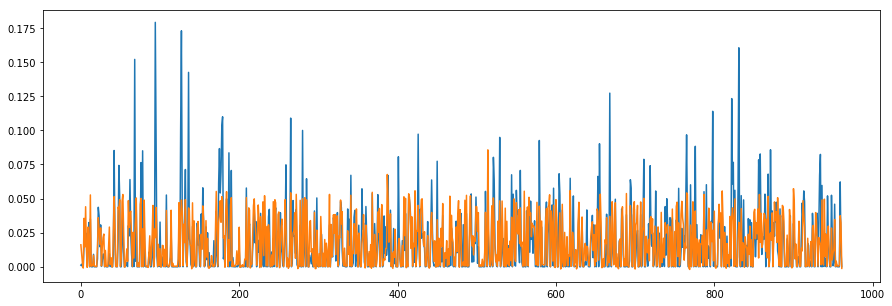

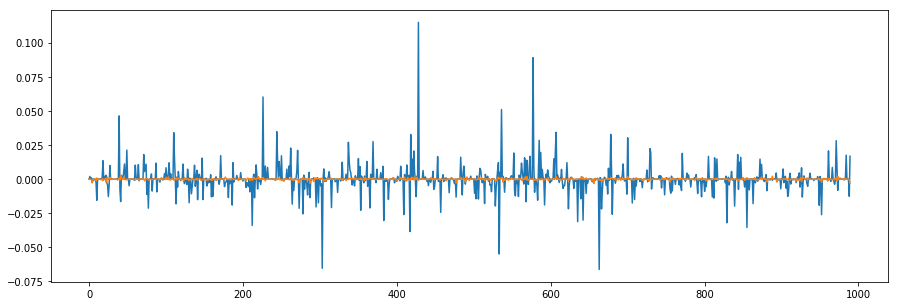

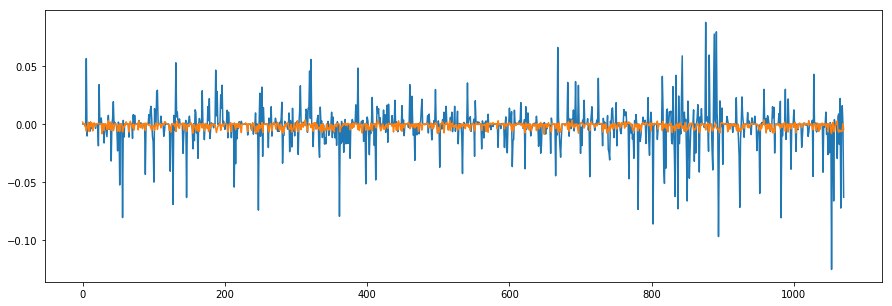

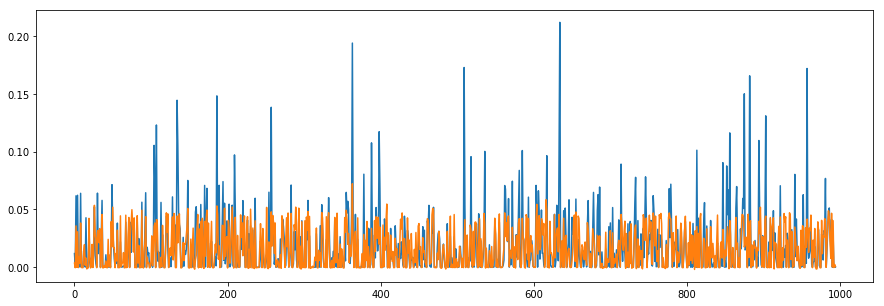

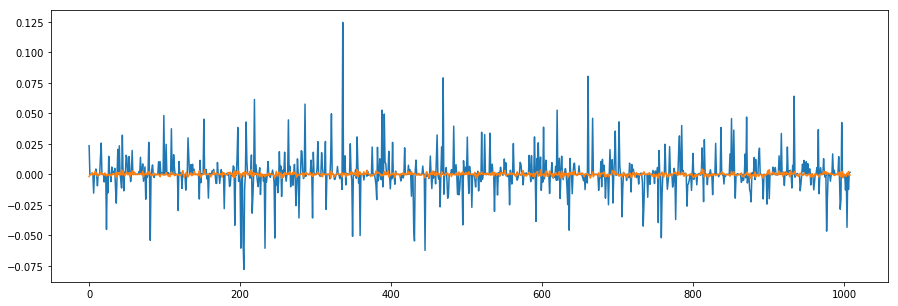

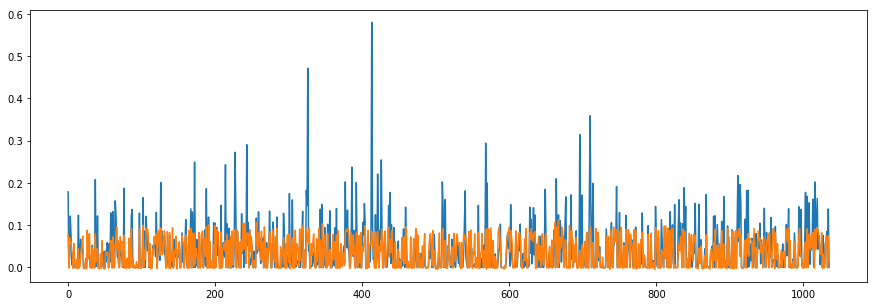

Shape of Output Files:
(146, 96, 75) (146, 96, 75) (146, 96, 75) (146, 96, 75) (146, 96, 75) (146, 96, 75)
Shape of Input Files:
(146, 96, 75)
(1051200, 4)
(1051200, 1) (1051200, 1) (1051200, 1) (1051200, 1) (1051200, 1) (1051200, 1)




(525756, 4)
(525444, 4)






525756 train samples
525444 test samples
(525756, 4)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_176 (Dense)            (None, 10)                50        
_________________________________________________________________
dense_177 (Dense)            (None, 10)                110       
_________________________________________________________________
dense_178 (Dense)            (None, 1)                 11        
Total params: 171
Trainable params: 171
Non-trainable params: 0
_________________________________________________________________
Train on 525756 samples, validate on 525444 samples
Epoch 1/20
525756/525756 [=========

525756/525756 [==============================] - 8s 16us/step - loss: 0.9970 - mean_squared_error: 0.9970 - val_loss: 0.9898 - val_mean_squared_error: 0.9898
Epoch 17/20
525756/525756 [==============================] - 8s 16us/step - loss: 0.9970 - mean_squared_error: 0.9970 - val_loss: 0.9895 - val_mean_squared_error: 0.9895
Epoch 18/20
525756/525756 [==============================] - 8s 16us/step - loss: 0.9969 - mean_squared_error: 0.9969 - val_loss: 0.9896 - val_mean_squared_error: 0.9896
Epoch 19/20
525756/525756 [==============================] - 8s 16us/step - loss: 0.9969 - mean_squared_error: 0.9969 - val_loss: 0.9900 - val_mean_squared_error: 0.9900
Epoch 20/20
525756/525756 [==============================] - 9s 16us/step - loss: 0.9970 - mean_squared_error: 0.9970 - val_loss: 0.9895 - val_mean_squared_error: 0.9895
Test loss: 0.9894847033087802
Test accuracy: 0.9894847033087802
_________________________________________________________________
Layer (type)                 Out

525756/525756 [==============================] - 9s 17us/step - loss: 0.5126 - mean_squared_error: 0.5126 - val_loss: 0.5135 - val_mean_squared_error: 0.5135
Epoch 13/20
525756/525756 [==============================] - 8s 16us/step - loss: 0.5112 - mean_squared_error: 0.5112 - val_loss: 0.5108 - val_mean_squared_error: 0.5108
Epoch 14/20
525756/525756 [==============================] - 8s 16us/step - loss: 0.5100 - mean_squared_error: 0.5100 - val_loss: 0.5097 - val_mean_squared_error: 0.5097
Epoch 15/20
525756/525756 [==============================] - 8s 16us/step - loss: 0.5088 - mean_squared_error: 0.5088 - val_loss: 0.5086 - val_mean_squared_error: 0.5086
Epoch 16/20
525756/525756 [==============================] - 8s 16us/step - loss: 0.5076 - mean_squared_error: 0.5076 - val_loss: 0.5069 - val_mean_squared_error: 0.5069
Epoch 17/20
525756/525756 [==============================] - 8s 16us/step - loss: 0.5064 - mean_squared_error: 0.5064 - val_loss: 0.5067 - val_mean_squared_error:

525756/525756 [==============================] - 8s 15us/step - loss: 0.6079 - mean_squared_error: 0.6079 - val_loss: 0.6011 - val_mean_squared_error: 0.6011
Epoch 11/20
525756/525756 [==============================] - 8s 14us/step - loss: 0.6072 - mean_squared_error: 0.6072 - val_loss: 0.6008 - val_mean_squared_error: 0.60080.6059 - mean_squared_error: 0.60 - ETA: 0s - loss: 0.6067 - mean_squared_error: 
Epoch 12/20
525756/525756 [==============================] - 8s 15us/step - loss: 0.6066 - mean_squared_error: 0.6066 - val_loss: 0.5997 - val_mean_squared_error: 0.5997
Epoch 13/20
525756/525756 [==============================] - 8s 14us/step - loss: 0.6060 - mean_squared_error: 0.6060 - val_loss: 0.5992 - val_mean_squared_error: 0.5992
Epoch 14/20
525756/525756 [==============================] - 8s 15us/step - loss: 0.6055 - mean_squared_error: 0.6055 - val_loss: 0.5984 - val_mean_squared_error: 0.5984
Epoch 15/20
525756/525756 [==============================] - 8s 14us/step - loss:

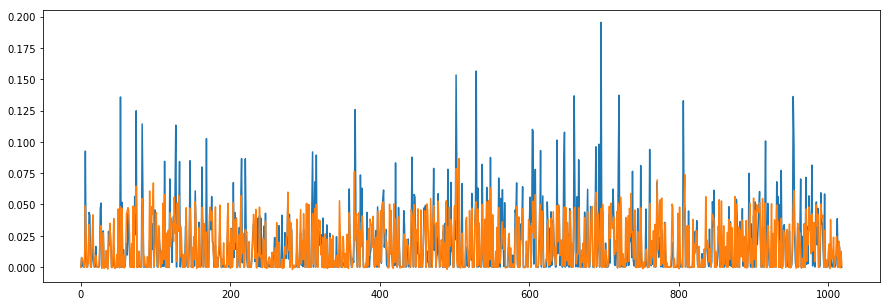

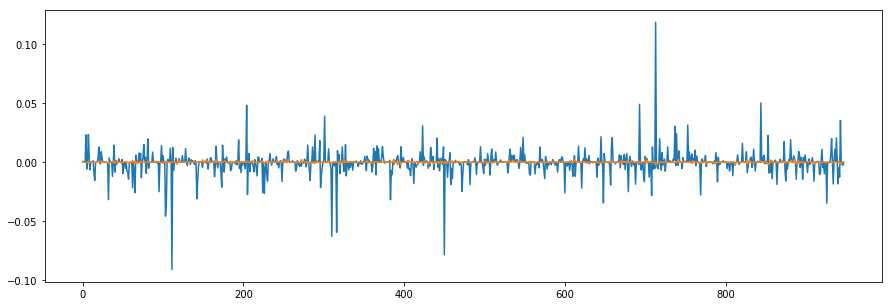

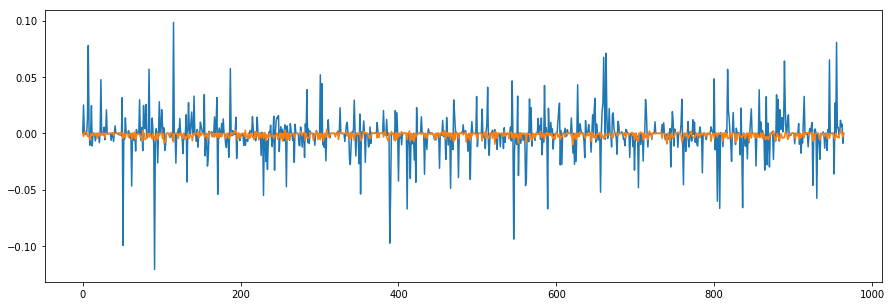

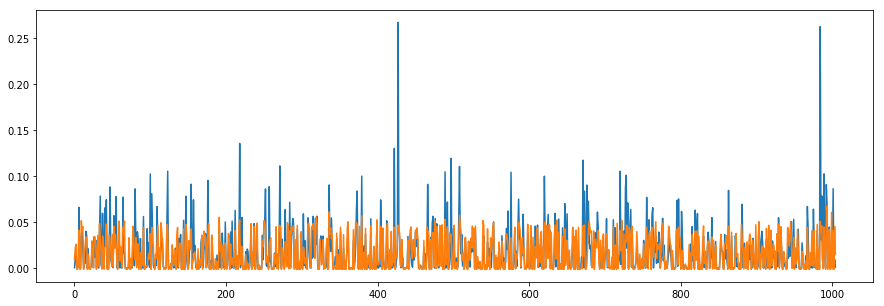

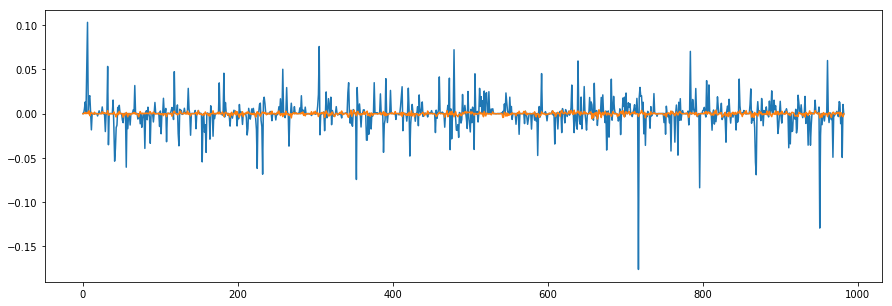

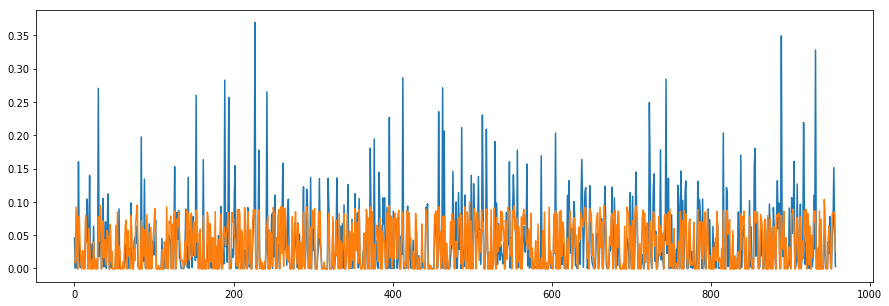

Shape of Output Files:
(146, 96, 75) (146, 96, 75) (146, 96, 75) (146, 96, 75) (146, 96, 75) (146, 96, 75)
Shape of Input Files:
(146, 96, 75)
(146, 96, 75)
(array([ 1,  1,  1, ..., 72, 72, 72]), array([ 1,  1,  1, ..., 94, 94, 94]), array([ 1,  2,  3, ..., 71, 72, 73]))










X_train shape (494064, 3, 3, 3, 4)
tau_train shape (494064, 1)
494064 train samples
494064 test samples
(494064, 3, 3, 3, 4)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_11 (Conv3D)           (None, 1, 1, 1, 128)      13952     
_________________________________________________________________
activation_11 (Activation)   (None, 1, 1, 1, 128)      0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 128)               0         
_________________________________________________________________
dense_194 (Dense)            (None, 16)                2064      

494064/494064 [==============================] - 350s 709us/step - loss: 0.3376 - mean_squared_error: 0.3376 - val_loss: 0.4271 - val_mean_squared_error: 0.4271
Epoch 14/20
494064/494064 [==============================] - 352s 713us/step - loss: 0.3344 - mean_squared_error: 0.3344 - val_loss: 0.4204 - val_mean_squared_error: 0.4204
Epoch 15/20
494064/494064 [==============================] - 319s 646us/step - loss: 0.3318 - mean_squared_error: 0.3318 - val_loss: 0.4259 - val_mean_squared_error: 0.4259
Epoch 16/20
494064/494064 [==============================] - 317s 642us/step - loss: 0.3291 - mean_squared_error: 0.3291 - val_loss: 0.4169 - val_mean_squared_error: 0.4169
Epoch 17/20
494064/494064 [==============================] - 319s 646us/step - loss: 0.3259 - mean_squared_error: 0.3259 - val_loss: 0.4211 - val_mean_squared_error: 0.4211
Epoch 18/20
494064/494064 [==============================] - 317s 641us/step - loss: 0.3236 - mean_squared_error: 0.3236 - val_loss: 0.4269 - val_m

Epoch 8/20
494064/494064 [==============================] - 318s 644us/step - loss: 0.1500 - mean_squared_error: 0.1500 - val_loss: 0.1888 - val_mean_squared_error: 0.1888
Epoch 9/20
494064/494064 [==============================] - 318s 643us/step - loss: 0.1478 - mean_squared_error: 0.1478 - val_loss: 0.1886 - val_mean_squared_error: 0.1886
Epoch 10/20
494064/494064 [==============================] - 319s 646us/step - loss: 0.1458 - mean_squared_error: 0.1458 - val_loss: 0.1898 - val_mean_squared_error: 0.1898
Epoch 11/20
494064/494064 [==============================] - 319s 645us/step - loss: 0.1440 - mean_squared_error: 0.1440 - val_loss: 0.1876 - val_mean_squared_error: 0.1876
Epoch 12/20
494064/494064 [==============================] - 318s 643us/step - loss: 0.1421 - mean_squared_error: 0.1421 - val_loss: 0.1866 - val_mean_squared_error: 0.1866
Epoch 13/20
494064/494064 [==============================] - 318s 644us/step - loss: 0.1408 - mean_squared_error: 0.1408 - val_loss: 0.18

494064/494064 [==============================] - 318s 643us/step - loss: 0.1734 - mean_squared_error: 0.1734 - val_loss: 0.1933 - val_mean_squared_error: 0.1933
Epoch 3/20
494064/494064 [==============================] - 317s 642us/step - loss: 0.1618 - mean_squared_error: 0.1618 - val_loss: 0.1810 - val_mean_squared_error: 0.1810
Epoch 4/20
494064/494064 [==============================] - 318s 643us/step - loss: 0.1555 - mean_squared_error: 0.1555 - val_loss: 0.1764 - val_mean_squared_error: 0.1764
Epoch 5/20
494064/494064 [==============================] - 318s 643us/step - loss: 0.1513 - mean_squared_error: 0.1513 - val_loss: 0.1763 - val_mean_squared_error: 0.1763
Epoch 6/20
494064/494064 [==============================] - 318s 643us/step - loss: 0.1480 - mean_squared_error: 0.1480 - val_loss: 0.1700 - val_mean_squared_error: 0.1700
Epoch 7/20
494064/494064 [==============================] - 318s 643us/step - loss: 0.1453 - mean_squared_error: 0.1453 - val_loss: 0.1722 - val_mean_s

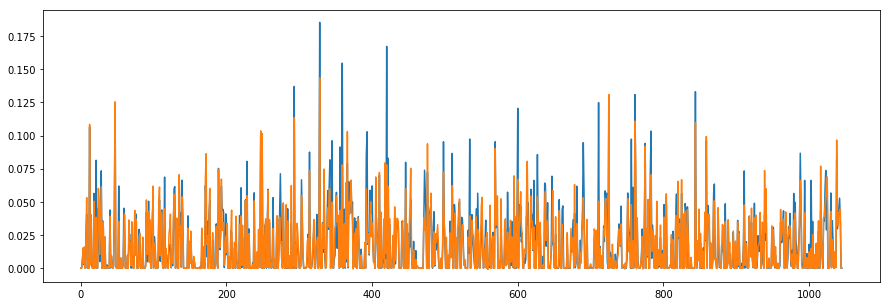

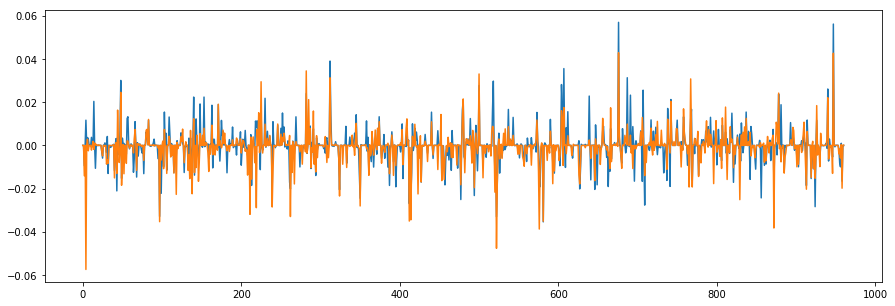

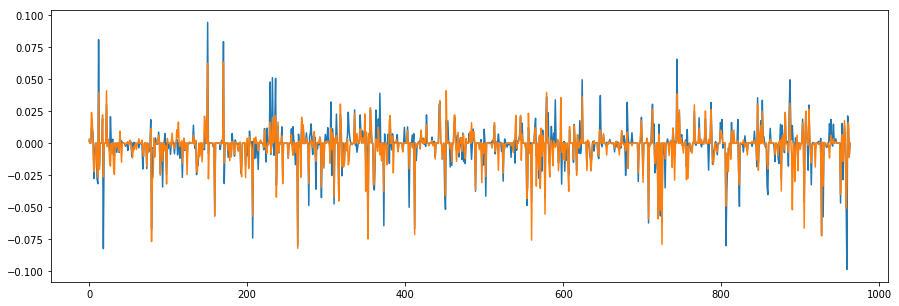

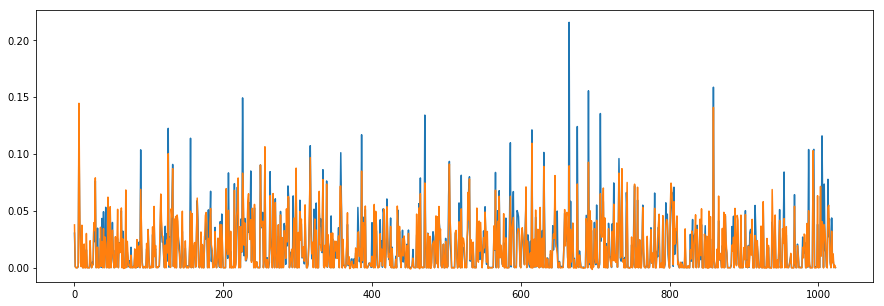

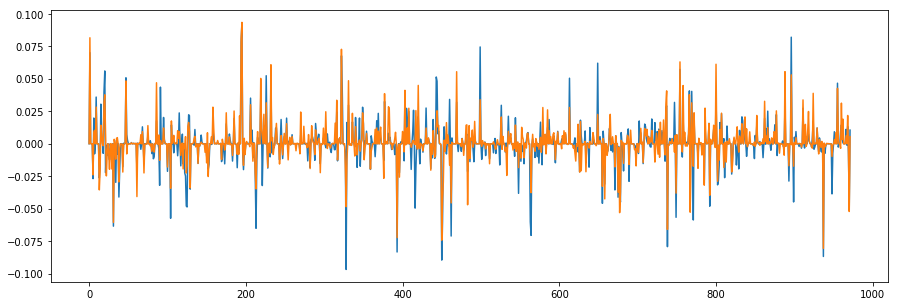

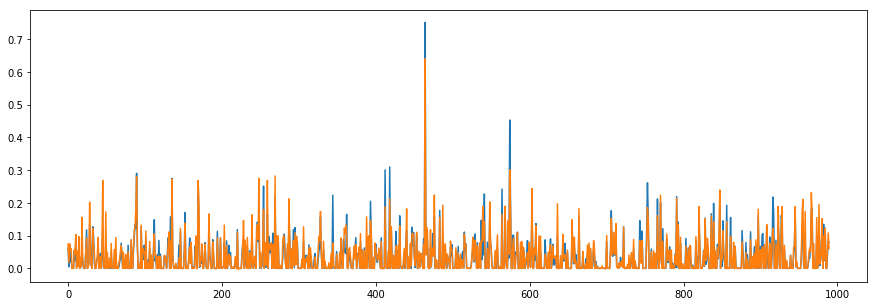

In [237]:
model_nn_1, results_nn_1 = main('one-layer NN', 1)
model_nn_2, results_nn_2 = main('two-layer NN', 1)
model_conv_3d, results_conv_3d = main('conv-3d NN', 3)

In [239]:
results_nn_1

[(array([[1.        , 0.69128054],
         [0.69128054, 1.        ]]), 0.018301971244576203),
 (array([[1.       , 0.0523396],
         [0.0523396, 1.       ]]), 0.009273993939453452),
 (array([[1.        , 0.13948263],
         [0.13948263, 1.        ]]), 0.015934335479178743),
 (array([[1.        , 0.69427993],
         [0.69427993, 1.        ]]), 0.018161323284751216),
 (array([[1.       , 0.0815695],
         [0.0815695, 1.       ]]), 0.015933367740122904),
 (array([[1.        , 0.62905948],
         [0.62905948, 1.        ]]), 0.04198677745002861)]

In [240]:
results_nn_2

[(array([[1.        , 0.71140839],
         [0.71140839, 1.        ]]), 0.017790104799482145),
 (array([[1.        , 0.05785792],
         [0.05785792, 1.        ]]), 0.009250143810950129),
 (array([[1.        , 0.13780409],
         [0.13780409, 1.        ]]), 0.015928830981191005),
 (array([[1.        , 0.70551124],
         [0.70551124, 1.        ]]), 0.017896246930783382),
 (array([[1.        , 0.09160915],
         [0.09160915, 1.        ]]), 0.015886190142667525),
 (array([[1.        , 0.63255719],
         [0.63255719, 1.        ]]), 0.041851624938358985)]

In [241]:
results_conv_3d

[(array([[1.        , 0.90650221],
         [0.90650221, 1.        ]]), 0.010663141908193468),
 (array([[1.        , 0.76932786],
         [0.76932786, 1.        ]]), 0.006004731584325964),
 (array([[1.       , 0.8142811],
         [0.8142811, 1.       ]]), 0.009672868051615147),
 (array([[1.        , 0.91146716],
         [0.91146716, 1.        ]]), 0.010348182977120923),
 (array([[1.        , 0.82096789],
         [0.82096789, 1.        ]]), 0.009360621777568854),
 (array([[1.        , 0.91594809],
         [0.91594809, 1.        ]]), 0.022785622510792695)]

Shape of Output Files:
(146, 96, 75) (146, 96, 75) (146, 96, 75)
Shape of Input Files:
(146, 96, 75)
(1051200, 5)
(1051200, 1) (1051200, 1) (1051200, 1)





(525586, 5)
(525614, 5)



525586 train samples
525614 test samples
(525586, 5)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_206 (Dense)            (None, 10)                60        
_________________________________________________________________
dense_207 (Dense)            (None, 1)                 11        
Total params: 71
Trainable params: 71
Non-trainable params: 0
_________________________________________________________________
Train on 525586 samples, validate on 525614 samples
Epoch 1/20
525586/525586 [==============================] - 10s 18us/step - loss: 0.9878 - mean_squared_error: 0.9878 - val_loss: 0.9692 - val_mean_squared_error: 0.9692
Epoch 2/20
525586/525586 [==============================] - 8s 15us/step - loss: 0

525586/525586 [==============================] - 8s 15us/step - loss: 0.9816 - mean_squared_error: 0.9816 - val_loss: 0.9821 - val_mean_squared_error: 0.9821
Epoch 20/20
525586/525586 [==============================] - 8s 15us/step - loss: 0.9814 - mean_squared_error: 0.9814 - val_loss: 0.9785 - val_mean_squared_error: 0.9785
Test loss: 0.9784669192852959
Test accuracy: 0.9784669192852959
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_210 (Dense)            (None, 10)                60        
_________________________________________________________________
dense_211 (Dense)            (None, 1)                 11        
Total params: 71
Trainable params: 71
Non-trainable params: 0
_________________________________________________________________
Train on 525586 samples, validate on 525614 samples
Epoch 1/20
525586/525586 [==============================] - 10s 19us/step - loss: 0.6964 - mean_sq

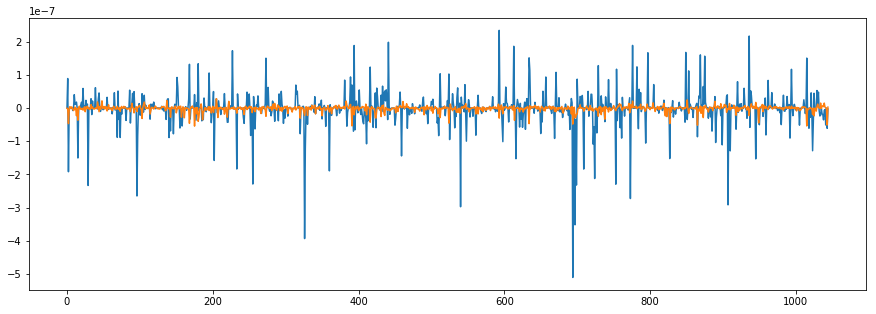

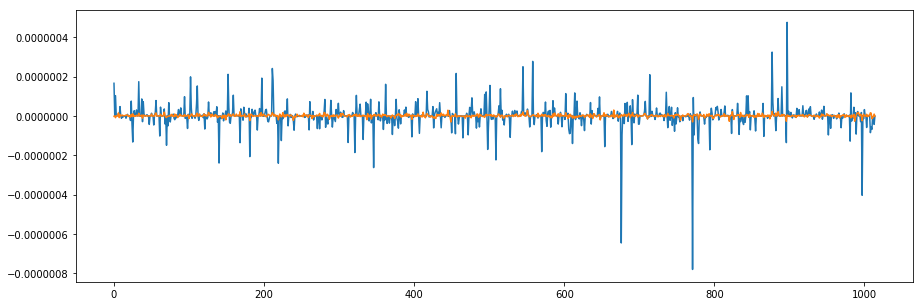

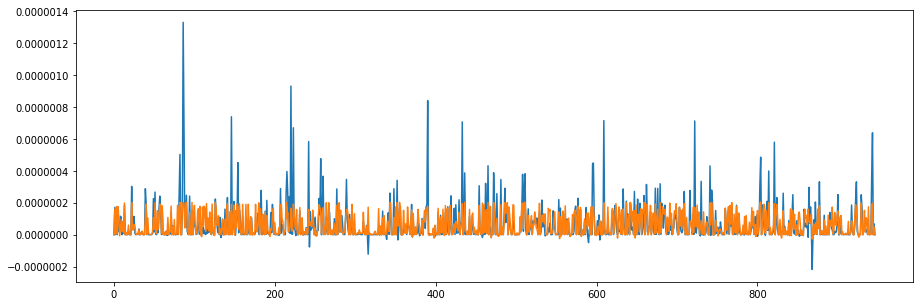

Shape of Output Files:
(146, 96, 75) (146, 96, 75) (146, 96, 75)
Shape of Input Files:
(146, 96, 75)
(1051200, 5)
(1051200, 1) (1051200, 1) (1051200, 1)





(525980, 5)
(525220, 5)



525980 train samples
525220 test samples
(525980, 5)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_212 (Dense)            (None, 10)                60        
_________________________________________________________________
dense_213 (Dense)            (None, 10)                110       
_________________________________________________________________
dense_214 (Dense)            (None, 1)                 11        
Total params: 181
Trainable params: 181
Non-trainable params: 0
_________________________________________________________________
Train on 525980 samples, validate on 525220 samples
Epoch 1/20
525980/525980 [==============================] - 10s 19us/step - loss: 0.9910 - mean_squared_error: 0.9910 

525980/525980 [==============================] - 8s 16us/step - loss: 0.9826 - mean_squared_error: 0.9826 - val_loss: 0.9526 - val_mean_squared_error: 0.9526
Epoch 19/20
525980/525980 [==============================] - 8s 16us/step - loss: 0.9823 - mean_squared_error: 0.9823 - val_loss: 0.9520 - val_mean_squared_error: 0.9520
Epoch 20/20
525980/525980 [==============================] - 8s 16us/step - loss: 0.9822 - mean_squared_error: 0.9822 - val_loss: 0.9519 - val_mean_squared_error: 0.9519
Test loss: 0.9518585208186645
Test accuracy: 0.9518585208186645
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_218 (Dense)            (None, 10)                60        
_________________________________________________________________
dense_219 (Dense)            (None, 10)                110       
_________________________________________________________________
dense_220 (Dense)            (None, 1)    

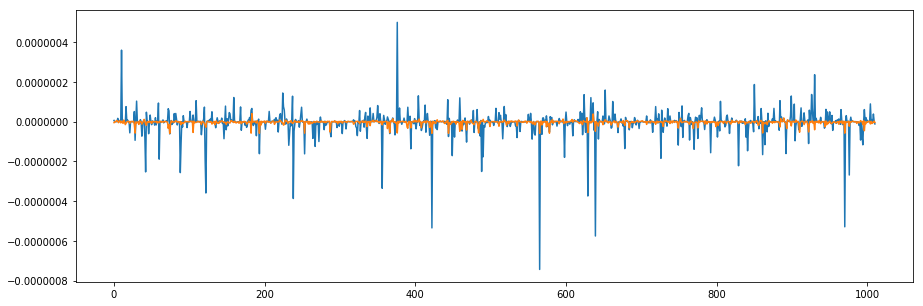

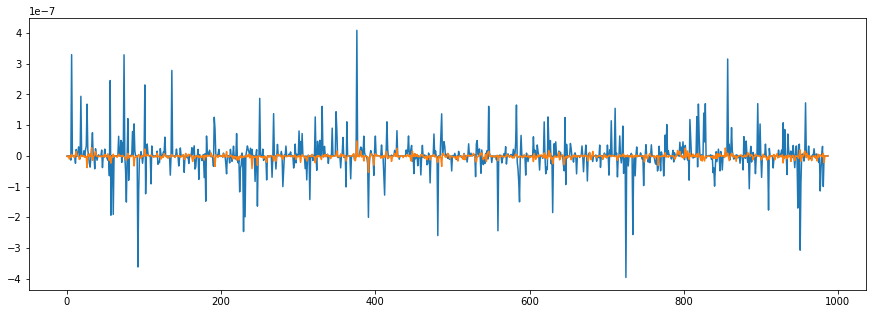

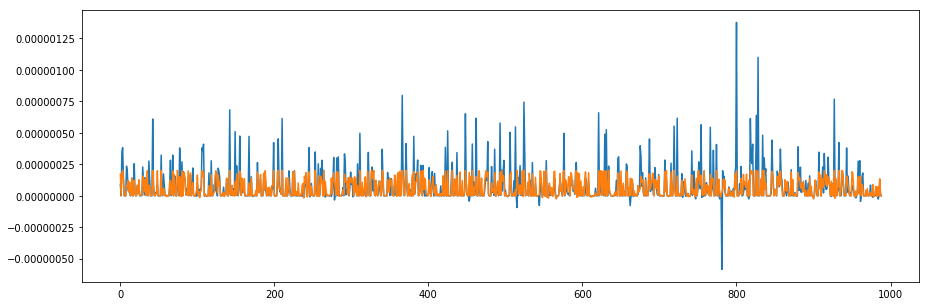

Shape of Output Files:
(146, 96, 75) (146, 96, 75) (146, 96, 75)
Shape of Input Files:
(146, 96, 75)
(146, 96, 75)
(array([ 1,  1,  1, ..., 72, 72, 72]), array([ 1,  1,  1, ..., 94, 94, 94]), array([ 1,  2,  3, ..., 71, 72, 73]))



(494064, 3, 3, 3, 5)





X_train shape (494064, 3, 3, 3, 5)
tau_train shape (494064, 1)
494064 train samples
494064 test samples
(494064, 3, 3, 3, 5)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_17 (Conv3D)           (None, 1, 1, 1, 128)      17408     
_________________________________________________________________
activation_17 (Activation)   (None, 1, 1, 1, 128)      0         
_________________________________________________________________
flatten_17 (Flatten)         (None, 128)               0         
_________________________________________________________________
dense_221 (Dense)            (None, 16)                2064      
______________________

Epoch 14/20
494064/494064 [==============================] - 324s 656us/step - loss: 0.6270 - mean_squared_error: 0.6270 - val_loss: 0.7222 - val_mean_squared_error: 0.7222
Epoch 15/20
494064/494064 [==============================] - 322s 653us/step - loss: 0.6248 - mean_squared_error: 0.6248 - val_loss: 0.7168 - val_mean_squared_error: 0.7168
Epoch 16/20
494064/494064 [==============================] - 323s 653us/step - loss: 0.6238 - mean_squared_error: 0.6238 - val_loss: 0.7156 - val_mean_squared_error: 0.7156
Epoch 17/20
494064/494064 [==============================] - 322s 653us/step - loss: 0.6219 - mean_squared_error: 0.6219 - val_loss: 0.7151 - val_mean_squared_error: 0.7151
Epoch 18/20
494064/494064 [==============================] - 323s 653us/step - loss: 0.6205 - mean_squared_error: 0.6205 - val_loss: 0.7158 - val_mean_squared_error: 0.7158
Epoch 19/20
494064/494064 [==============================] - 322s 652us/step - loss: 0.6194 - mean_squared_error: 0.6194 - val_loss: 0.

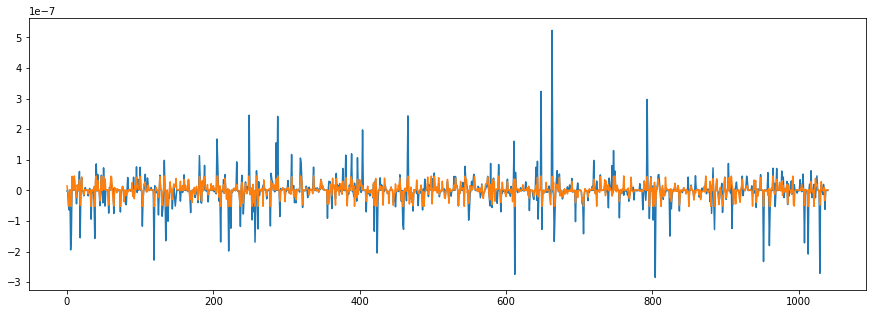

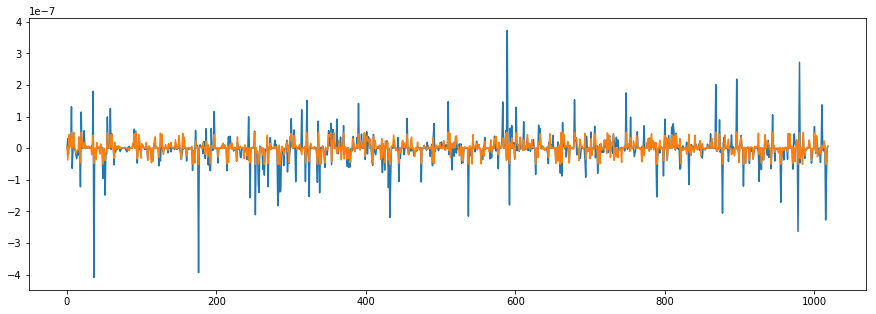

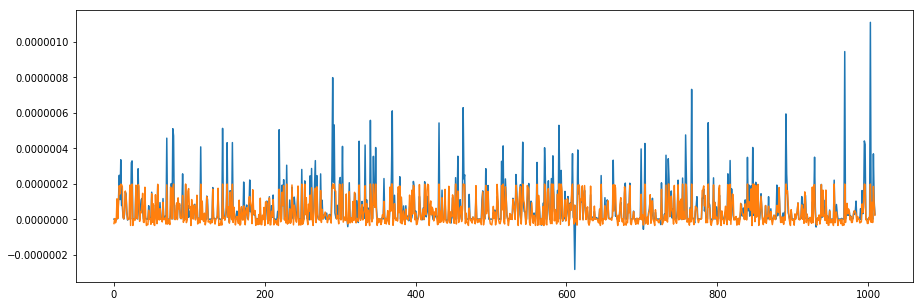

In [238]:
model_nn_1_heat, results_nn_1_heat = main_heat('one-layer NN', 1)
model_nn_2_heat, results_nn_2_heat = main_heat('two-layer NN', 1)
model_conv_3d_heat, results_conv_3d_heat = main_heat('conv-3d NN', 3)

In [242]:
results_nn_1_heat

[(array([[1.        , 0.22214517],
         [0.22214517, 1.        ]]), 5.423537704583692e-08),
 (array([[1.       , 0.1326358],
         [0.1326358, 1.       ]]), 5.4933549917546137e-08),
 (array([[1.        , 0.65760738],
         [0.65760738, 1.        ]]), 1.0036455536678398e-07)]

In [243]:
results_nn_2_heat

[(array([[1.        , 0.22925952],
         [0.22925952, 1.        ]]), 5.431780828535776e-08),
 (array([[1.        , 0.13592313],
         [0.13592313, 1.        ]]), 5.4546890420478587e-08),
 (array([[1.        , 0.66339873],
         [0.66339873, 1.        ]]), 1.0057676774645586e-07)]

In [245]:
results_conv_3d_heat

[(array([[1.        , 0.60753991],
         [0.60753991, 1.        ]]), 4.21258979259204e-08),
 (array([[1.       , 0.6133743],
         [0.6133743, 1.       ]]), 4.303750465959135e-08),
 (array([[1.        , 0.75129853],
         [0.75129853, 1.        ]]), 8.801370931803983e-08)]